# FX Graph QAT

以 [resnet18_cifar10_relu_cutout](cifar10-resnet18-relu) 网络为例展示如何进行 QAT FX Graph 训练。

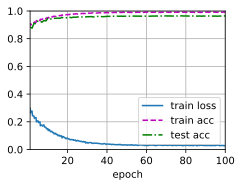

In [1]:
import logging
import torch
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights
from torch.ao.quantization import get_default_qat_qconfig_mapping
from torch.ao.quantization.quantize_fx import prepare_qat_fx, convert_fx
from torch_book.vision.classifier import Classifier, evaluate_accuracy
from torch_book.datasets.cifar10 import Cifar10
torch.cuda.empty_cache() # 清空 GPU 缓存
from torch_book.transforms.cutout import Cutout

logging.basicConfig(filename='logs/debug-graph.log',
                    filemode="a",
                    format='%(asctime)s|%(levelname)s|%(name)s->%(funcName)s@%(message)s',
                    level=logging.INFO)

num_epochs = 100

model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(model.conv1.in_channels, 
                        model.conv1.out_channels,
                        3, 1, 1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)
state_dict = torch.load("params/resnet18_cifar10_relu_cutout.h5")
model.load_state_dict(state_dict)
data = Cifar10(batch_size = 128, num_workers=4, cutout=Cutout(1, 16))
train_iter = data.train_loader()
test_iter = data.val_loader()

xs, _ = next(iter(train_iter))
model_qat = torch.fx.symbolic_trace(model)
model_qat = torch.fx.GraphModule(model_qat, model_qat.graph)
qconfig_mapping = get_default_qat_qconfig_mapping("qnnpack")
model_prepared = prepare_qat_fx(model_qat, qconfig_mapping, (xs,))
model_prepared = model_prepared.train()
classifier = Classifier(model_prepared, train_iter, test_iter, device=torch.device("cuda:1"))
classifier.prepare_optimizer(lr=0.0142857, momentum=0.857142,
                             weight_decay=0.000857142)
classifier.prepare_scheduler(lr_period=2, lr_decay=0.857142)
classifier.prepare_animator(num_epochs)
classifier.fit(num_epochs)

In [2]:
test_acc = evaluate_accuracy(classifier.mod, classifier.test_iter, device=torch.device("cuda:1"))
test_acc

0.9642

转换为量化模型：

In [4]:
from copy import deepcopy


new_model = deepcopy(classifier.mod)
new_model = new_model.to(torch.device("cpu")).eval()
model_converted = convert_fx(new_model).eval()

In [5]:
test_acc = evaluate_accuracy(model_converted, classifier.test_iter, device=torch.device("cpu"))
test_acc

0.9633

保存到本地：

In [7]:
data = Cifar10(batch_size=1)
test_iter = data.val_loader()
train_iter = data.train_loader()
inp, _ = next(iter(train_iter))
script_module = torch.jit.trace(model_converted.eval(), (inp,))
torch.jit.save(script_module, "params/resnet18_cifar10_relu_qat.h5")

Files already downloaded and verified
Files already downloaded and verified


重新加载并测试精度：

In [10]:
batch_size = 100
data = Cifar10(batch_size=batch_size)
test_iter = data.val_loader()
device = torch.device("cpu")
model = torch.jit.load("params/resnet18_cifar10_relu_qat.h5").eval()
test_acc = evaluate_accuracy(model, test_iter, device)
test_acc

Files already downloaded and verified


0.9633